In [1]:
from pdb import set_trace
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
from scipy.integrate import cumulative_trapezoid
from scipy.constants import Boltzmann


from gfatpy.config import set_logger_level
from gfatpy.lidar.preprocessing import preprocess
from gfatpy.lidar import utils
from gfatpy.utils.utils import moving_average
from gfatpy.lidar.utils import sigmoid
from gfatpy.lidar.retrieval import klett, raman
from gfatpy.lidar.retrieval.raman import retrieve_extinction, retrieve_backscatter
from gfatpy.utils.plot import color_list
from gfatpy.lidar.retrieval.synthetic.generator import generate_particle_properties, synthetic_signals
from gfatpy.lidar.utils.types import ParamsDict
from gfatpy.atmo.atmo import generate_meteo_profiles
from gfatpy.atmo import atmo, ecmwf


set_logger_level("WARNING")

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Read data

In [2]:
RS_FL = r"../tests/datos/PRODUCTS/mulhacen/1a/2021/07/05/mhc_1a_Prs_rs_xf_20210705.nc"

lidar = preprocess(RS_FL,
    channels=["532xpa"],
)
z = lidar.range.values


### Create a synthetic profile

C:\Users\Usuario\AppData\Local\Temp\ipykernel_30664\1269291186.py:75: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(alpha_part/beta_part, z, lw=4, color = 'black', label='synthetic')


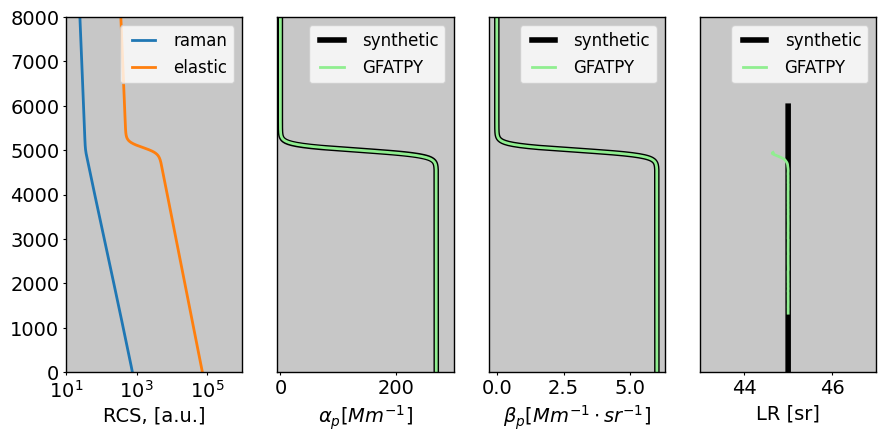

In [14]:
wavelength = 532
ecmwf_data = ecmwf.get_ecmwf_temperature_pressure(datetime(2022, 9, 3), heights=z)
P = ecmwf_data.pressure.values
T = ecmwf_data.temperature.values
atmo_data = atmo.molecular_properties(wavelength, P, T, heights=z)
wavelength_raman = 607
atmo_data_raman = atmo.molecular_properties(wavelength_raman, P, T, heights=z)

N = np.array(ecmwf_data.pressure.values) / (np.array(ecmwf_data.temperature.values) * Boltzmann)
    
# Implementar la inversion raman asumiendo que no hay particulas
beta_mol = atmo_data["molecular_beta"].values
alpha_mol = atmo_data["molecular_alpha"].values
beta_mol_raman = atmo_data_raman["molecular_beta"].values
alpha_mol_raman = atmo_data_raman["molecular_alpha"].values
ae_mol = np.mean(-np.log(alpha_mol/alpha_mol_raman)/np.log(wavelength/wavelength_raman))

# Generate synthetic particle properties
synthetic_beta = 6e-6
beta_part = sigmoid(
    z, 5000, 1 / 60, coeff=-synthetic_beta, offset=synthetic_beta
)
lr = 45
alpha_part = lr * beta_part
ae_part = 1
cte = 1 + (wavelength_raman/wavelength)**(-ae_part)
alpha_part_raman = alpha_part *(wavelength_raman/wavelength)**(-ae_part)
#No particles
# alpha_part_raman = alpha_part = beta_part = np.zeros(len(z))
# cte = 1

T_raman = np.exp(-cumulative_trapezoid(alpha_mol_raman + alpha_part_raman, z, initial=0))  # type: ignore
T_elastic = np.exp(-cumulative_trapezoid(alpha_mol+ alpha_part, z, initial=0))  # type: ignore
k_lidar_elastic = 1e10
k_lidar_raman = 1e9
overlap = 1
P_raman = k_lidar_raman * (overlap / z**2) * beta_mol_raman * T_elastic * T_raman
P_elastic = k_lidar_elastic * (overlap / z**2) * (beta_part + beta_mol) * T_elastic**2
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10, 5))

#Plot RCS_raman
ax[0].plot(P_raman*z**2, z, lw= 2, label="raman")
ax[0].plot(P_elastic*z**2, z, lw= 2, label="elastic")
ax[0].set_xscale('log')
ax[0].set_xlim(1e1,1e6)
ax[0].set_ylim(0,8000)
ax[0].set_xlabel('RCS, [a.u.]')
ax[0].legend()

alpha_part_gfatpy = retrieve_extinction(P_raman, z, (532, 607), P, T, window_size_m=100)
#Plot Extinction
ax[1].plot(1e6*alpha_part, z, lw=4, color = 'black', label='synthetic')
ax[1].plot(1e6*alpha_part_gfatpy, z, lw=2, color = 'lightgreen', label='GFATPY')
ax[1].set_xscale('linear')
ax[1].set_yticks([])
ax[1].set_xlim(-5,300)
ax[1].set_ylim(0,8000)
ax[1].set_xlabel(r'$\alpha_{p} [Mm^{-1}]$')
ax[1].legend()

#Plot beta
beta_part_gfatpy = retrieve_backscatter(P_raman, P_elastic, alpha_part_gfatpy, z, (532, 607), P, T)
ax[2].plot(1e6*beta_part, z, lw=4, color = 'black', label='synthetic')
ax[2].plot(1e6*beta_part_gfatpy, z, lw=2, color = 'lightgreen', label='GFATPY')
ax[2].set_xscale('linear')
ax[2].set_yticks([])
ax[2].set_ylim(0,8000)
ax[2].set_xlabel(r'$\beta_{p} [Mm^{-1}\cdot sr^{-1}]$')
ax[2].legend()

#Plot LR
R = beta_part_gfatpy/beta_mol + 1 
R_threshold = 6
LR_profile = alpha_part_gfatpy/beta_part_gfatpy
ax[3].plot(alpha_part/beta_part, z, lw=4, color = 'black', label='synthetic')
ax[3].plot(LR_profile[R>R_threshold], z[R>R_threshold], lw=2, color = 'lightgreen', label='GFATPY')
ax[3].set_xscale('linear')
ax[3].set_yticks([])
ax[3].set_ylim(0,8000)
ax[3].set_xlim(43,47)
ax[3].set_xlabel('LR [sr]')
ax[3].legend()


